In [ ]:
### This script only apply on the synonymous candidate before applying to FDR correction
### Flag the candidate genes with small non-coding region and the genes that have overlapped synonymous mutation with other regions.

***Filtering the genes that fall out of the non-coding window?***

In [1]:
import numpy as np

In [2]:
### Plot the non-coding length distribution and highlight the gene fall out of the region
# All plotting functions and parameters as in Figures.ipynb
import pickle, os, matplotlib
import matplotlib.pyplot as plt
# from matplotlib.colors import LinearSegmentedColormap
# from matplotlib.ticker import ScalarFormatter
import pandas as pd
import seaborn as sns
from matplotlib import gridspec
from collections import Counter
from matplotlib_venn import venn3, venn3_circles
import numpy as np
from matplotlib.patches import Rectangle

# settings
plt.interactive(False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
def set_snsfont(s):
    sns.set(font_scale=s)
    sns.set_style("white")
set_snsfont(1)

# output directory
dir_in = '../manuscript/figures_data/'
dir_out = '../manuscript/figures/'

if not os.path.exists(dir_out):
    os.makedirs(dir_out)
    
### Generate the label dictionary
dir_cohort = '../anno_ref/cohorts'
feature_type = 'histology'
df_feat = pd.read_csv(os.path.join(dir_cohort,feature_type+'.csv'))
dict_feat_np = dict(Counter(df_feat[feature_type]))
dict_feat_np = {k: v for k, v in sorted(dict_feat_np.items(), key=lambda item: item[1])}

In [66]:
### Read the synonymous candidate list/maf directory
dir_out_fig4 = './figure4/'
feature_type = 'histology';syn_nsyn = 'syn';run = 'cohort_090821'
df_syn = pd.read_csv(os.path.join(dir_out_fig4,feature_type+'.syn.df_all_forheatmap.'+run+'.csv'),index_col = 0)

In [4]:
### Read the non-coding length information
### Transcript info and name dict
dict_transcript_info = pickle.load(open('../anno_ref/proc_refs/dict_transcript_info_062121.pkl','rb'))
dict_name = pickle.load(open('../anno_ref/proc_refs/dict_name_062121.pkl','rb'))

In [5]:
### Create the transcript information
#Transcript - [exon/ncd length ration, noncoding length]
dict_transcript_ncdlen = {}
for transcripts in dict_transcript_info:
    length = dict_transcript_info[transcripts]['transcript']
    length = abs(length[1]-length[0])
    # get exon length
    exon_len = 0
    for x in dict_transcript_info[transcripts]['CDS']:
        exon_len += abs(x[1]-x[0])
    ncd_len = length-exon_len
    if ncd_len == 0:
        exon_ncd_ratio = 5000
    else:
        exon_ncd_ratio = exon_len/ncd_len
    dict_transcript_ncdlen[transcripts] = [exon_ncd_ratio,ncd_len]

# Gene name - [exon/ncd length ration, noncoding length]
dict_name_ncdlen = {}
for transcripts in dict_transcript_info:
    name = dict_name[transcripts]
    dict_name_ncdlen[name] = dict_transcript_ncdlen[transcripts]

In [6]:
### Distribution of noncoding length and exon,noncoding length ratio
df_ncd_length = pd.DataFrame.from_dict(dict_name_ncdlen).transpose()
df_ncd_length.columns = ['exon/ncd len ratio','ncd len']
# Option: Convert the len ratio to log10 scale
df_ncd_length['transformed exon/ncd len ratio'] = np.log10(df_ncd_length['exon/ncd len ratio'])
df_ncd_length.loc[df_ncd_length['ncd len'] == 0, 'ncd len'] = 0.001
df_ncd_length['transformed ncd len'] = np.log10(df_ncd_length['ncd len'])

In [7]:
# Add hue of candidate and non-candidate genes
gene_candid = df_syn['gene'].unique().tolist()
df_ncd_length.loc[gene_candid, 'sig_genes'] = 'Y'
not_sig = [i for i in df_ncd_length.index if i not in gene_candid]
df_ncd_length.loc[not_sig, 'sig_genes'] = 'N'
# df_ncd_length.loc[lx,'lowq'] = 'low_cov'

/storage/home/yur97/anaconda3/envs/mSigsyn/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The set_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


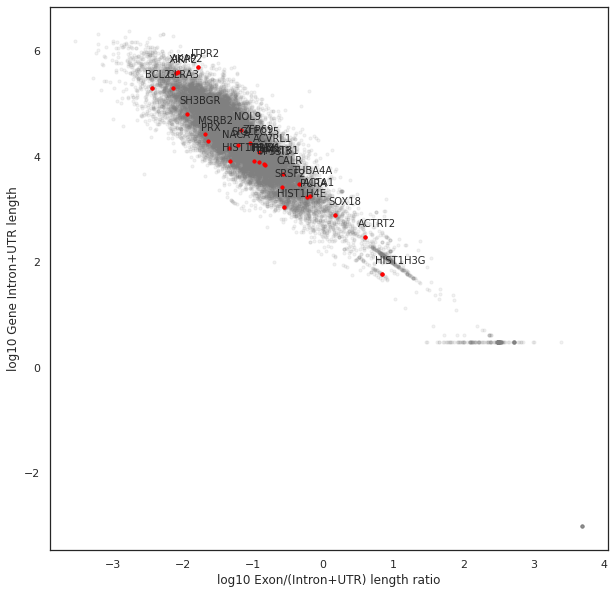

In [8]:
# The dataframe only for significant genes
df_ncd_sig = df_ncd_length.loc[gene_candid, ]

fig, ax = plt.subplots(figsize = (10,10))
# First plot to get the position of significant genes for annotation
ax.scatter(x=df_ncd_sig['transformed exon/ncd len ratio'], \
           y=df_ncd_sig['transformed ncd len'], c = 'red', s=10)

offset = ax.collections[0]
offset.set_offset_position('data')
datapos = offset.get_offsets()

# for dot and their positions, if pass the threshold, then annotate
for i in range(len(datapos)):
    xval = datapos[i][0];yval = datapos[i][1]
    # Find the term corresponding to the position
    termname = df_ncd_sig[df_ncd_sig['transformed exon/ncd len ratio'] == xval].index.values[0]
    ax.annotate(termname, (xval-0.1,yval +0.2), fontsize=10)

# Second plot to visualize the whole distribution for all genes
ax.scatter(x=df_ncd_length['transformed exon/ncd len ratio'], y=df_ncd_length['transformed ncd len'], c = 'grey', s=10, alpha = 0.1)
ax.scatter(x=df_ncd_sig['transformed exon/ncd len ratio'], \
           y=df_ncd_sig['transformed ncd len'], c = 'red', s=10)

# Set x y label
ax.set_ylabel('log10 Gene Intron+UTR length'); ax.set_xlabel('log10 Exon/(Intron+UTR) length ratio')

plt.show()

***Overlapping regions of genes***

In [9]:
import json, re, requests,sys
server = "https://grch37.rest.ensembl.org"

In [10]:
### Maf file folder
dir_maf = '../maf_out/maf_cohorts_060121'
feature_type = 'histology'

In [11]:
### function of sending request to ensembl
def get_overlapping_cons(muts):
    ext = '/vep/human/region/'+muts
    r = requests.get(server+ext,headers={"Content-Type" : "application/json"})

    if not r.ok:
      r.raise_for_status()
      sys.exit()

    decoded = r.json()
    
    return decoded[0]['transcript_consequences']

In [66]:
### Get the synonymous mutations of the candidate gene in the cohort
def get_syn_mut(gene, hist):
    global df_syn
    # open maf file
    df_maf = pd.read_csv(os.path.join(dir_maf,feature_type, hist+'.csv'), sep = '\t')
    df_maf = df_maf.set_index(['Hugo_Symbol','Variant_Classification','Donor_ID' ])
    # total number of donors in this cohort
    ldonor_all = df_maf.index.get_level_values('Donor_ID').unique().tolist()
    #print(f'Total {len(ldonor_all)} patients')
    
    # Find synonymous mutations
    df_gene_synmut = df_maf.loc[pd.IndexSlice[gene, 'Silent',:],:]### All patients' specific histology in this histology type
    df_gene_synmut = df_gene_synmut[df_gene_synmut['Variant_Type'] == 'SNP']
    df_gene_intmut = df_maf.loc[pd.IndexSlice[gene, 'Intron',:],:]### All patients' specific histology in this histology type
    df_gene_intmut = df_gene_intmut[df_gene_intmut['Variant_Type'] == 'SNP']
    # Number of patients have synonymous mutations
    # ldonor = df_gene_mut.index.get_level_values('Donor_ID').unique().tolist()

    return df_gene_synmut, df_gene_intmut

In [62]:
def find_ovp(mutations, gene):
    # start overlap dictionary
    dict_ovp = {}
    dict_ovp[mutations] = {}
    # format mutationf for sending request to ensembl
    chromosome, pos = re.findall(r'\d+', mutations)
    ref,alt = re.findall(r'[A-Z]', mutations)
    muts = f'{chromosome}:{pos}:{pos}/{alt}?'
    res = get_overlapping_cons(muts)
    # Analyze result
    for cons in res:
        ovpgene = cons['gene_symbol']
        ovpcons = cons['consequence_terms']
        # if it's not the target gene, append to dictionary
        if ovpgene!= gene and ovpgene not in dict_ovp[mutations]:
            dict_ovp[mutations][ovpgene] = []
        if ovpgene!= gene and ovpcons not in dict_ovp[mutations][ovpgene]:
            dict_ovp[mutations][ovpgene].append(ovpcons)
    return dict_ovp

In [63]:
res = find_ovp('17:74732997A>C', 'SRSF2')

In [70]:
dict_ovp_all = {}
for genes in df_syn['gene']:
    dict_ovp_all[genes] = {}
    dict_ovp_all[genes]['syn'] = {};dict_ovp_all[genes]['intron'] = {};
    histology = df_syn.loc[df_syn['gene'] == genes,'feature'].values[0]
    df_synmut,df_intmut = get_syn_mut(genes, histology)
    for mutation in df_synmut['Genome_Change'].unique().tolist():
        res = find_ovp(mutation , genes)
        dict_ovp_all[genes]['syn'].update(res)
    for mutation in df_intmut['Genome_Change'].unique().tolist():
        res = find_ovp(mutation , genes)
        dict_ovp_all[genes]['intron'].update(res)

In [73]:
import pickle
pickle.dump(dict_ovp_all, open('dict_ovp_all.pkl', 'wb'))

In [ ]:
import pickle

In [3]:
dict_ovp_all = pickle.load(open('dict_ovp_all.pkl', 'rb'))

In [5]:
dict_ovp_all['BCL2']

{'syn': {'g.chr18:60985471G>A': {'RP11-28F1.2': [['upstream_gene_variant']]},
  'g.chr18:60985492C>T': {'RP11-28F1.2': [['upstream_gene_variant']]},
  'g.chr18:60985573G>A': {'RP11-28F1.2': [['upstream_gene_variant']]},
  'g.chr18:60985366A>G': {'RP11-28F1.2': [['upstream_gene_variant']]},
  'g.chr18:60985435C>T': {'RP11-28F1.2': [['upstream_gene_variant']]},
  'g.chr18:60985834C>T': {'RP11-28F1.2': [['upstream_gene_variant']]},
  'g.chr18:60985876C>A': {'RP11-28F1.2': [['upstream_gene_variant']]},
  'g.chr18:60985833G>A': {'RP11-28F1.2': [['upstream_gene_variant']]},
  'g.chr18:60985359G>A': {'RP11-28F1.2': [['upstream_gene_variant']]},
  'g.chr18:60985366A>T': {'RP11-28F1.2': [['upstream_gene_variant']]},
  'g.chr18:60985861C>T': {'RP11-28F1.2': [['upstream_gene_variant']]},
  'g.chr18:60985549G>A': {'RP11-28F1.2': [['upstream_gene_variant']]},
  'g.chr18:60985711C>A': {'RP11-28F1.2': [['upstream_gene_variant']]},
  'g.chr18:60985876C>T': {'RP11-28F1.2': [['upstream_gene_variant']]},

In [9]:
nUniqSyn = len(dict_ovp_all['BCL2']['syn'])
nUniqIntron = len(dict_ovp_all['BCL2']['intron'])

In [1]:
def anlyze_ovp(gene):
    dictNone = {}; dictNone[gene] = {}; dictNone[gene]['intron'] = [];dictNone[gene]['syn'] = []
    dictOvp_loose = {}; dictOvp_loose[gene] = {}; dictOvp_loose[gene]['intron'] = [];dictOvp_loose[gene]['syn'] = []
    # strict overlap -- exclude upstream and downstream variants
    dictOvp_strict = {};dictOvp_strict[gene] = {}; dictOvp_strict[gene]['intron'] = [];dictOvp_strict[gene]['syn'] = []  
    for mut in dict_ovp_all[gene]['intron']:
        cons = list(dict_ovp_all[gene]['intron'][mut].values())
        if not cons: # This dict is empty -- not overlap with anything
            dictNone[gene]['intron'].append(mut)
        elif any(x not in ['upstream_gene_variant', 'downstream_gene_variant'] for x in cons[0][0]):
            dictOvp_strict[gene]['intron'].append(mut)
        else:
            dictOvp_loose[gene]['intron'].append(mut)

    for mut in dict_ovp_all[gene]['syn']:
        cons = list(dict_ovp_all[gene]['syn'][mut].values())
        if not cons: # This dict is empty -- not overlap with anything
            dictNone[gene]['syn'].append(mut)
        elif any(x not in ['upstream_gene_variant', 'downstream_gene_variant'] for x in cons[0][0]):
            dictOvp_strict[gene]['syn'].append(mut)
        else:
            dictOvp_loose[gene]['syn'].append(mut)
    
    print(f'Gene:{gene}')
    print(f"Intron Mutation: Total:{len(dict_ovp_all[gene]['intron'])};No ovp{len(dictNone[gene]['intron'])};\
    Loose ovp:{len(dictOvp_loose[gene]['intron'])} ; Strict ovp: {len(dictOvp_strict[gene]['intron'])}")
    
    print(f"Syn Mutation: Total:{len(dict_ovp_all[gene]['syn'])};No ovp{len(dictNone[gene]['syn'])};\
    Loose ovp:{len(dictOvp_loose[gene]['syn'])} ; Strict ovp: {len(dictOvp_strict[gene]['syn'])}")

In [2]:
for genes in df_syn['gene']:
    anlyze_ovp(genes)

NameError: name 'df_syn' is not defined